<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.983 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios d'Informàtica, Multimèdia y Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRACTICA: Implementació d'un agent per a la robòtica espacial


## 1. Presentació

Al llarg de les tres parts de l'assignatura hem entrat en contacte amb diferents classes d'algoritmes d'aprenentatge per reforç que permeten resoldre problemes de control en una gran varietat d'entorns.

Aquesta pràctica, que s'estendrà al llarg d'un mes aproximadament, dóna la possibilitat d'enfrontar-se al disseny d'un agent per solucionar un cas específic de robotica.

Atacarem el problema a partir de l'exploració de l'entorn i les observacions. Després passarem a la selecció de l'algorisme més oportú per solucionar l'entorn en qüestió amb les observacions seleccionades. Finalment, passarem per l'entrenament i la prova de l'agent fins a arribar a l'anàlisi del rendiment.

Per fer-ho, es presentarà abans l'entorn de referència. Posteriorment, es passarà a la implementació d'un agent Deep Q-Network (DQN) que el solucioni. Després d'aquestes dues primeres fases de presa de contacte amb el problema, es cercarà un altre agent que pugui millorar el rendiment de l'agent DQN implementat anteriorment.

## 2. Competències
En aquesta activitat es treballen les següents competències:

● Capacitat per analitzar un problema des del punt de vista de l'aprenentatge per reforç.

● Capacitat per analitzar un problema en el nivell d'abstracció adequat a cada situació i aplicar les habilitats i coneixements adquirits per resoldre'ls.


## 3. Objectius
Els objectius concrets d'aquesta activitat són:

● Conèixer i aprofundir en el desenvolupament d'un entorn real que es pugui resoldre mitjançant tècniques d'aprenentatge per reforç.

● Aprendre a aplicar i comparar diferents mètodes d'aprenentatge per reforç per poder seleccionar el més adequat a un entorn i problemàtica concreta.

● Saber implementar els diferents mètodes, basats en solucions tabulars i solucions aproximades, per a resoldre un problema concret.

● Extreure conclusions a partir dels resultats obtinguts.

## 4. Entorn

Estem treballant sobre el problema de guia autònoma i en particular volem solucionar el cas de l’aterratge propi, per exemple, dels drons autònoms.

Per això, s'escull lunar-lander com a entorn simplificat. L'entorn es pot trobar al següent enllaç:
https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

Lunar Lander consisteix en una nau espacial que ha d'aterrar a un lloc determinat del camp d'observació. L'agent condueix la nau i el seu objectiu és aconseguir aterrar a la pista d'aterratge, coordenades (0,0), i arribar amb velocitat 0.

La nau consta de tres motors (esquerra, dreta i el principal que té a sota) que li permeten anar corregint el rumb fins a arribar a la destinació.

Les accions que pot fer la nau (espai d'accions) són discretes.

Les recompenses obtingudes al llarg del procés d'aterratge depenen de les accions que es prenen i del resultat que se'n deriva.

    ● Desplaçar-vos de dalt a baix, fins a la zona d'aterratge pot resultar en [+100,+140] punts

    ● Si s'estrella a terra, perd 100 punts (recompensa -100 punts)

    ● Si aconsegueix aterrar a la zona d'aterratge (velocitat 0), guanya +100 punts

    ● Si aterra, però no a la zona d'aterratge (fora de les banderes grogues) es perden punts

    ● El contacte d'una pota amb el terra rep +10 punts (si es perd contacte després d'aterrar, es perden punts)

    ● Cada cop que encén el motor principal perd 0.3 punts (recompensa -0.3 punts)

    ● Cada cop que encén un dels motors d'esquerra o dreta, perd 0,03 punts (recompensa -0.3 punts)

La solució òptima és aquella en què l'agent, amb un desplaçament eficient, aconsegueix aterrar a la zona d'aterratge (0,0), tocant amb les dues potes a terra i amb velocitat nul·la. Es considera que l'agent ha après a fer la tasca (i.e. el “joc” acaba) quan obté una mitjana d'almenys 200 punts durant 100 episodis consecutius.

In [1]:
import warnings
import time
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
!pip install gym[atari]==0.25.0
!pip install autorom[accept-rom-license]
!pip install gym[box2d]
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
from copy import deepcopy
from datetime import datetime

In [2]:
# Comprovació de la versió de GYM instal·lada
print('La versió de gym instal·lada: ' + gym.__version__)

# Comprovació d'entorn amb gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("L'entorn utilitza: ", device)

La versió de gym instal·lada: 0.25.0
L'entorn utilitza:  cpu


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 1.1 (0.5 punts)</strong> Es demana explorar l’entorn i representar una execució aleatòria.
</div>


In [3]:
warnings.filterwarnings('ignore')
env = gym.make('LunarLander-v2')

print("- Rang de recompenses o llindar de les recompenses: {} ".format(env.reward_range))
print("- Màxim nombre de passos per episodi: {} ".format(env.spec.max_episode_steps)) 
print("- Espai d'accions: {} ".format(env.action_space.n))
print("- Espai d'estats continuu: {} ".format(env.continuous))
print("- Espai d'observacions: {} ".format(env.observation_space))


- Rang de recompenses o llindar de les recompenses: (-inf, inf) 
- Màxim nombre de passos per episodi: 1000 
- Espai d'accions: 4 
- Espai d'estats continuu: False 
- Espai d'observacions: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32) 


Hem pogut veure que el llindar de recompenses pot anar des de -infinit fins a +infinit. També que per cada episodi tenim un màxim de 1000 passos. Les accions són 4 que les comentarem en el següent exercici i aquestes són discretas (es pot configurar per a que siguin continues). L'espai d'observacions l'hem visualitzat i també el comentarem més endavant. Ara farem una execució aleatoria.

In [4]:
# inicialitzem l'entorn
obs = env.reset()
t, total_reward, done = 0, 0, False

# mostrem informació inicial
print("Obs: {}".format(obs))

while not done:
    
    # escollim la acció aleatoria
    action = env.action_space.sample()
    
    # executem la acció i obtenim el nou estat, la recompensa i si hem acabat    
    new_obs, reward, done, info = env.step(action)
    
    # mostrem informació
    print("\nObs: {} \nAcció: {} \nRecompensa: {} \nDone: {}".format(new_obs, action, reward, done))

    # Actualizar variables
    obs = new_obs
    total_reward += reward
    t += 1
    
print("Episodi finalitzat després de {} passos i recompensa de {} ".format(t, total_reward))
env.close()

Obs: [ 0.00719328  1.4139918   0.7285917   0.13650253 -0.00832848 -0.16503683
  0.          0.        ]

Obs: [ 0.01438303  1.4173045   0.7272668   0.14716205 -0.01652326 -0.16390994
  0.          0.        ] 
Acció: 2 
Recompensa: -1.5300384330619068 
Done: False

Obs: [ 0.02158403  1.4213395   0.72841156  0.17921498 -0.02472934 -0.16413751
  0.          0.        ] 
Acció: 2 
Recompensa: -2.345960812297636 
Done: False

Obs: [ 0.02872314  1.4263124   0.7226282   0.22085279 -0.03335376 -0.17250459
  0.          0.        ] 
Acció: 2 
Recompensa: -2.2212393909479884 
Done: False

Obs: [ 0.03580675  1.432189    0.717513    0.26095006 -0.0424021  -0.18098362
  0.          0.        ] 
Acció: 2 
Recompensa: -2.595128249801081 
Done: False

Obs: [ 0.04281463  1.4374733   0.7079905   0.23463511 -0.04953007 -0.14257284
  0.          0.        ] 
Acció: 1 
Recompensa: 0.4731638846642465 
Done: False

Obs: [ 0.04972906  1.442176    0.6962491   0.20883895 -0.05428603 -0.09512774
  0.          0

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 1.2 (0.5 punts)</strong>
Explicar els espais d'observacions i d'accions possibles (informe escrit).    
</div>

- Espai d'accions: com hem vist en l'exercici anterior l'espai d'accions és de 4. Hem definit un espai discret (podria ser continu). Les accions són les següents: 
    - Nop (no fer res)
    - Fire left engine (motor esquerra)
    - Main engine (motor principal)
    - Right engine (motor dret)
    

- Espai d'observacions: l'espai d'observacions està formada per un vector amb 8 coordenades.
    - la coordenada de x
    - la coordenada de y
    - la velocitat linear de x
    - la velocitat linear de y
    - l'angle
    - la velocitat angular
    - dos boolean que diuen si cada una de les potes està en contacte amb el terra

Anem a executar 1000 prenent accions de forma aleatòria. Emmagatzerem tant la suma de recompenses de cada partida com la quantitat d'episodis executats.

In [5]:
def play_games(num_games):    
    steps_list = []
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        total_reward, steps, done = 0, 0, False
        env.reset()
        while not done:         
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            total_reward += reward
            steps += 1
            if done:    
                steps_list.append(steps)
                total_reward_list.append(total_reward)
    return steps_list, total_reward_list      
          
steps_list, total_reward_list = play_games(1000)
env.close()   

Episode 999/1000.

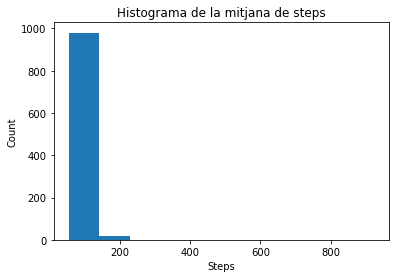

In [6]:
plt.hist(steps_list)
plt.title('Histograma de la mitjana de steps')
plt.xlabel('Steps')
plt.ylabel('Count')
plt.show()

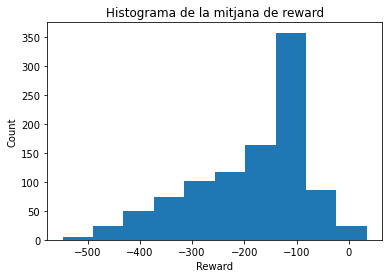

In [7]:
plt.hist(total_reward_list)
plt.title('Histograma de la mitjana de reward')
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

In [8]:
print("La mitjana de les passes per episodi és de: {} ".format(np.mean(steps_list)))
print("La mitjana de les recompenses per episodi és de: {} ".format(np.mean(total_reward_list)))

La mitjana de les passes per episodi és de: 92.388 
La mitjana de les recompenses per episodi és de: -186.77527200189232 


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
La mitjana de passes és del voltant de mes de 90 i la recomenpensa mitjana dels episodis és força negatiu. Fent servir algoritmes Deep Q-Networks hauriem d'aconseguir millorar aquests valors de recompensa ja que hem triat accions totalment aleatories. 
</div>

## 5. Agent de referència

A la tercera part de l'assignatura hem introduït l'agent DQN amb replay buffer i target network, que és un bon candidat per a la solució del problema de robòtica que estem analitzant, donat que permet controlar entorns amb un nombre elevat d'estats i accions de forma eficient.

Es demana resoldre els 3 exercicis següents.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.1 (1.5 punts):</strong> Implementar un agent DQN per a l'entorn lunar-lander.
</div>

Per entrenar una xarxa neuronal per resoldre el problema de "LunarLander-v2" fem servir una arquitectura amb una capa d'entrada amb 8 canals d'entrada (per cada un dels atributs de les observacions), una capa intermitja amb 32 entrades i 64 sortides i finalment una capa de sortida amb les 64 entrades i 4 sortides (una per cada una de les possibles accions).

In [61]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F

class DQNetwork(nn.Module):
    """ Deep Q-Network model  per a l'entrenament de l'agent DQN """
 
    def __init__(self, n_state, n_action, seed, n_layer1=64, n_layer2=64):
        """
        Inicialització de la xarxa neuronal
        Params
        =======
            n_state (int): Dimensions de l'espai d'estats
            n_action (int): Dimensions de l'espai d'accions
            n_layer1 (int): Nombre de nodes en la primera capa oculta
            n_layer2 (int): Nombre de nodes en la segona capa oculta
            seed (int): Random seed per a inicialitzar els valors aleatoris
        """
        super(DQNetwork, self).__init__()
        self.seed = T.manual_seed(seed)
        self.fc1 = nn.Linear(n_state, n_layer1)
        self.fc2 = nn.Linear(n_layer1, n_layer2)
        self.fc3 = nn.Linear(n_layer2, n_action)

    def forward(self, state):
        """
        Forward pass de la xarxa neuronal amb una capa oculta de 64 nodes i una capa de sortida de 4 nodes (una per cada acció)
        amb activació ReLU en les dues capes ocultes i activació lineal en la capa de sortida 
        """
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        return self.fc3(state)

Fem servir tant l'algorisme d'optimització Adam com mètode e-greedy per a que anem alternant accions aleatories amb accions de l'aprenentatge. Al principi totes són aleatories i posteriorment de forma incremental anem afegint del model.

Tal i com demana l'enunciat fem servir un buffer per evitar la repetició de accions seqüencials i evitar la correlació entre ellas. Alhora implementem una xarxa objectiu i una principal que evita que es vicii en excés l'aprenentatge, estabilitzar-lo i que no ens centrem només en uns certs espai d'accions.

In [62]:
class Agent:
    """ Agent que interactua amb l'entorn i apren a través de DQN"""    
    def __init__(self, env, seed, learning_rate=1e-3, gamma=0.99, tau=1e-3, buffer_size=100000, batch_size=64, dnn_upd=4):
        """ Inicialitza l'agent per a l'aprenentatge per DQN
            L'agent inicialitza la xarxa neuronal local i target, el buffer de memòria i l'optimitzador    
        Params
        ======
            env: Entorn de gym
            n_state (int): Dimensions de l'espai d'estats
            n_action (int): Dimensions de l'espai d'accions
            seed (int): Random seed per a inicialitzar els valors aleatoris
            learning_rate (float): Velocitat d'aprenentatge
            gamma (float): Valor gamma de l'equació de Bellman
            tau (float): Valor de tau per a soft update del target network
            buffer_size (int): Màxima capacitat del buffer
            batch_size (int): Conjunt a agafar del buffer per a la xarxa neuronal     
            dnn_upd (int): Freqüència d'actualització de la xarxa neuronal       
        """
        self.env = env
        self.seed = seed         
        self.n_state = env.observation_space.shape[0] 
        self.n_action = env.action_space.n
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.buffer_size = buffer_size
        self.batch_size = batch_size        
        self.dnn_upd = dnn_upd
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu") # Si hi ha GPU, utilitza-la

         
        random.seed(seed)   

        if T.cuda.is_available():
            print(f'Running on {T.cuda.get_device_name(0)}')            
        else:
            print('Running on CPU')
               
        # Inicialització de les xarxes locals i target i de l'optimitzador
        self.__initialize_networks()

    def __initialize_networks(self):
        # Inicialització de les xarxes locals i target            
        self.qnetwork_local = DQNetwork(self.n_state, self.n_action, self.seed).to(self.device)
        self.qnetwork_target = DQNetwork(self.n_state, self.n_action, self.seed).to(self.device)
        # Inicialització de l'optimitzador
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = self.learning_rate)

        # Inicialització del buffer de memòria
        self.memory = ReplayBuffer(self.n_action, self.buffer_size, self.batch_size, self.seed)
        
        # Inicialització del comptador de pasos per a l'actualització de la xarxa neuronal
        self.t_step = 0

    def __take_step(self, state, action, reward, next_state, done):
        """
        Afegeix l'experiència a la memòria i actualitza la xarxa neuronal
        """
        # emmagatzemar l'experiència en el buffer de memòria
        self.memory.append(state, action, reward, next_state, done)

        # Actualitzar la xarxa neuronal cada dnn_upd pasos
        self.t_step = (self.t_step + 1) % self.dnn_upd
        if self.t_step == 0:
            # Si hi ha suficients experiències en el buffer, agafar un lot i actualitzar la xarxa neuronal
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample_batch()
                self.__update(experiences, self.gamma)

    def get_action(self, state, eps):
        """
        Retorna l'acció segons l'estat actual i l'epsilon-greedy
        """
        state = T.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with T.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy per a seleccionar l'acció. 
        # Si el valor aleatori és més gran que l'epsilon agafar l'acció amb el valor més alt segons la xarxa neuronal
        # Si no, agafar una acció aleatòria
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.n_action))

    def __update(self, experiences, gamma):
        """
        Actualitza els pesos de la xarxa neuronal local i target
        """
        states, actions, rewards, next_states, dones = experiences

        # obtenir els valors Q de l'estat següent segons la xarxa neuronal target
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # calcular els valors Q segons l'equació de Bellman teni en compte si l'estat és terminal i el parametre gamma
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))

        # obtenir els valors Q de l'estat actual segons la xarxa neuronal local
        q_expected = self.qnetwork_local(states).gather(1, actions)

        # calcular la funció de pèrdua segons l'error quadràtic mitjà
        loss = F.mse_loss(q_expected, q_targets)

        # minimitzar la funció de pèrdua amb l'optimitzador
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

        # actualitzar els pesos de la xarxa neuronal target amb un soft update per a reduir el problema de l'estabilitat
        self.__soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def __soft_update(self, local_model, target_model, tau):
        """
        Soft update dels pesos de la xarxa neuronal target
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)    


    def train(self, n_episodes=2000, max_t=1000, eps_start=1.0, eps_min=0.01, eps_decay=0.995, nblock =100, min_episodes=250, reward_threshold=200.0):
        """Deep Q-Learning.

        Params
        ======
            n_episodes (int): nombre màxim d'episodis
            max_t (int): maxim nombre de pasos per episodi
            eps_start (float): valor inicial d'epsilon
            eps_min (float): valor mínim d'epsilon
            eps_decay (float): factor de decaig d'epsilon
        """
        self.reward_threshold = reward_threshold
        self.eps = eps_start  # inicialitzar epsilon
        self.nblock = nblock
        self.total_episodes = 0
        
        self.update_loss = [] 
        self.mean_update_loss = [] # llista amb els valors de la funció de pèrdua per episodi
        
        self.sync_eps = [] 

        self.training_rewards = []  # llista amb els reward per episodi
        self.mean_training_rewards = []  # llista amb la mitjana dels reward per episodi

        start_time = datetime.now()
        print("Training...")
        
        for episode in range(1, n_episodes + 1):
            state = self.env.reset()
            self.total_reward = 0   
            self.total_time = 0
            
            for t in range(max_t):
                action = self.get_action(state, self.eps)
                next_state, reward, done, _ = self.env.step(action)
                self.__take_step(state, action, reward, next_state, done)
                state = next_state
                self.total_reward += reward
                if done:
                    break

            # actualitzar epsilon
            self.eps = max(eps_min, eps_decay * self.eps)  # decrease epsilon            
            
            # afegir el reward de l'episodi a la llista
            self.__save_statistics()
            
            # mostrar informació de l'episodi actual
            self.__log_info(start_time, episode)
            
            ### comprovar si s'ha assolit el màxim d'episodis
            training = not self.__is_solved_by_episode(episode, n_episodes) and not self.__is_solved_by_reward(episode, min_episodes, self.__get_mean_training_rewards())
                        
            ### si no s'ha assolit el màxim d'episodis, continuar entrenant
            if not training:
                print('\nTraining finished.')
                self.total_time = datetime.now() - start_time
                self.total_episodes = episode
                break

            if episode % 100 == 0:
                print('\rEpisode {}\tMean Rewards: {:.2f}\t'.format(episode, self.__get_mean_training_rewards()))
  

    def __get_mean_training_rewards(self):
        return np.mean(self.training_rewards[-self.nblock:])

    ######## Emmagatzemar epsilon, training rewards i loss#######
    def __save_statistics(self):
        self.sync_eps.append(self.eps)              
        self.training_rewards.append(self.total_reward)         
        self.mean_training_rewards.append(np.mean(self.training_rewards[-self.nblock:]))
        self.mean_update_loss.append(np.mean(self.update_loss))                                         
        self.update_loss = []
   
    ######## Comprovar si s'ha arribat al llindar de recompensa i un mínim d'episodis
    def __is_solved_by_reward(self, episode, min_episodios, mean_rewards):  
        if mean_rewards >= self.reward_threshold and min_episodios <  episode:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, mean_rewards))
            T.save(self.qnetwork_local.state_dict(), 'data.pth')
            return True
        else:
            return False

    ######## Comprovar si s'ha arribat al màxim d'episodis
    def __is_solved_by_episode(self, episode, max_episodes):
        if episode >= max_episodes:
            print('\nEpisode limit reached.')
            return True
        else:
            return False        


    ######## Mostrar informació de l'episodi actual
    def __log_info(self, start_time, episode):
        end_time = datetime.now()
        # get difference time
        delta = end_time - start_time 
        # time difference in minutes
        total_minutes = delta.total_seconds() / 60           
        print('\rEpisode {}\tMean Rewards: {:.2f}\tEpsilon {}\tTime {} minutes\t'
              .format(episode, self.__get_mean_training_rewards(), round(self.eps,4), round(total_minutes,2)), end="")                    

In [63]:
from collections import deque, namedtuple
import random
import numpy as np

import torch as T

class ReplayBuffer:
            
    """ Definim la classe ReplayBuffer que ens permetrà guardar les experiències de l'agent i poder-les reutilitzar posteriorment. """

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """ Inicialitzem els paràmetres de la classe ReplayBuffer.
        Params
        ======
            action_size (int): dimension de l'espai d'accions
            buffer_size (int): mida del buffer
            batch_size (int): tamany de la mostra del batch
            seed (int): seed per inicialitzar el generador de nombres aleatoris
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

    def append(self, state, action, reward, next_state, done):
        """ Afegeix una experiència al buffer de memòria. """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample_batch(self):
        """ Retorna una mostra aleatòria de tamany batch_size experiències del buffer de memòria.  """
        experiences = random.sample(self.memory, k=self.batch_size)

        states = T.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = T.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = T.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = T.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = T.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """ Retorna el tamany actual del buffer de memòria. """
        return len(self.memory)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.2 (1 punt):</strong> Entreneu l'agent DQN i busqueu els valors dels hiperparàmetres que obtinguin un alt rendiment de l'agent. Per fer-ho, cal llistar els hiperparàmetres sota estudi i presentar les gràfiques de les mètriques que descriuen l'aprenentatge.
</div>

Afegim els paràmetres base amb els que realitzarem l'entrenament.

In [ ]:
BUFFER_SIZE = 100000    # Màxima capacitat del buffer
BATCH_SIZE = 64         # Conjunt a agafar del buffer per a la xarxa neuronal
GAMMA = 0.99            # Valor gamma de l'equació de Bellman
TAU = 1e-3              # Valor de tau per a soft update del target network
LEARNING_RATE = 5e-4    # Velocitat d'aprenentatge
DNN_UPD = 3             # Freqüència d'actualització de la xarxa neuronal

N_EPISODES=2000
MAX_T=1000 
EPS_START=1.0
EPS_MIN=0.01
EPS_DECAY=0.995
NBLOCK =100
MIN_EPISODES=250
REWARD_THRESHOLD = 200  # Valor de recompensa per a considerar l'entrenament com a completat

In [60]:
# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')

LEARNING_RATE = [1e-3, 5e-4, 1e-4]              # Velocitat d'aprenentatge
DNN_UPD = [1, 3, 5]              # Freqüència d'actualització de la xarxa neuronal
EPS_DECAY = [0.99, 0.995]                # Decaiment de l'exploració

agents = []
n_test = 1
# iteració per a buscar els millors paràmetres
for lr in LEARNING_RATE:
    for upd in DNN_UPD:
        for eps in EPS_DECAY:
            print("Test Number: ",n_test)
            print("Learning rate: ", lr, " DNN update: ", upd, " Epsilon decay: ", eps)
            agent = Agent(env, seed=0, learning_rate=lr, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=upd)
            scores = agent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, eps, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)
            agents.append(agent)
            print("Mean reward: ", agent.mean_training_rewards[-1])
            print("Mean loss: ", agent.mean_update_loss[-1])
            print("Epsilon: ", agent.sync_eps[-1])
            print("Steps: ", agent.t
            print("")
                  
# tanquem l'entorn de gym
env.close()

SyntaxError: invalid syntax (Temp/ipykernel_23676/3087730821.py, line 40)

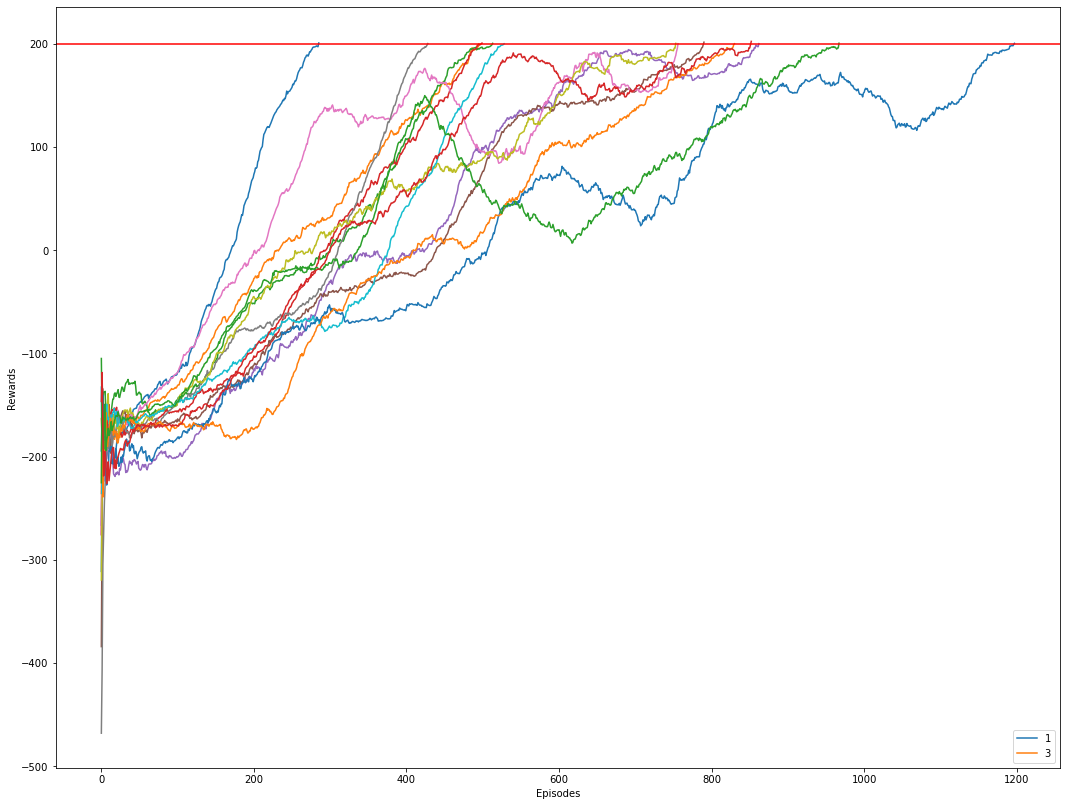

In [54]:
# plot de la recompensa de tots els agents en una mateixa gràfica
for idx,agent in enumerate(agents):    
        if max(agent.mean_training_rewards) > 200:
            plt.plot(agent.mean_training_rewards, label='Test Number' + idx)

plt.legend()        
plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')        
plt.rcParams['figure.figsize'] = [18, 14]
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 2.3 (0.5 punts):</strong> Visualitzar-ne el comportament (a través de
gràfiques de les mètriques més oportunes).
</div>

In [58]:
def plot_rewards(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.training_rewards, label='Rewards')
        plt.plot(agent.mean_training_rewards, label='Mean Rewards')
        plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

def plot_loss(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.mean_update_loss, label='Loss')
        plt.xlabel('Episodes')
        plt.ylabel('Loss')
        plt.legend(loc="upper left")
        plt.show()
        
def plot_epsilon(agent):
        plt.figure(figsize=(12,8))
        plt.plot(agent.sync_eps, label='Epsilon')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')
        plt.legend(loc="upper left")
        plt.show()

Running on CPU
Training...
Episode 100	Mean Rewards: -136.72	Epsilon 0.6058	Time 0.57 minutes	
Episode 200	Mean Rewards: -64.58	Epsilon 0.367	Time 1.91 minutes			
Episode 300	Mean Rewards: 14.48	Epsilon 0.2223	Time 6.19 minutes		
Episode 400	Mean Rewards: 149.08	Epsilon 0.1347	Time 10.21 minutes	
Episode 448	Mean Rewards: 201.44	Epsilon 0.1059	Time 11.46 minutes	
Environment solved in 348 episodes!	Average Score: 201.44

Training finished.


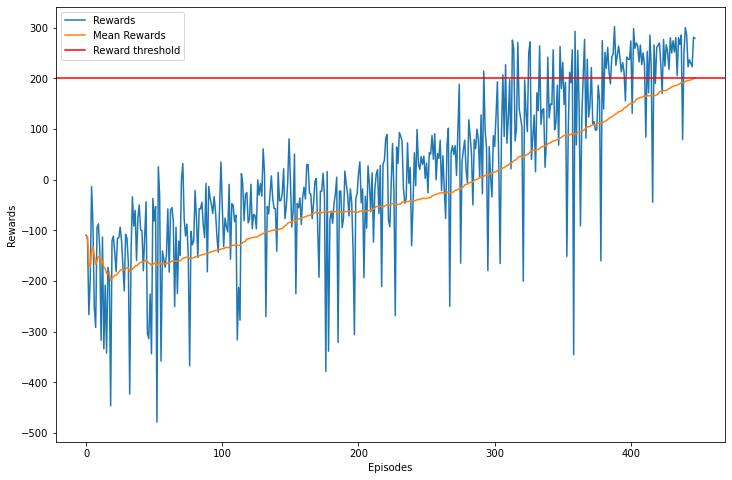

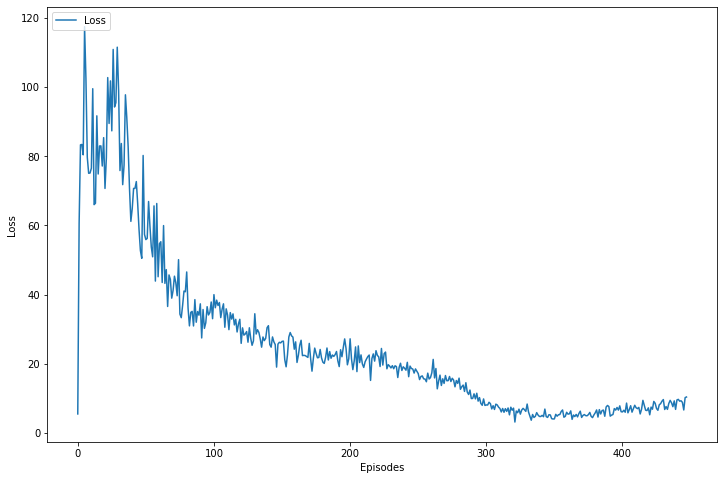

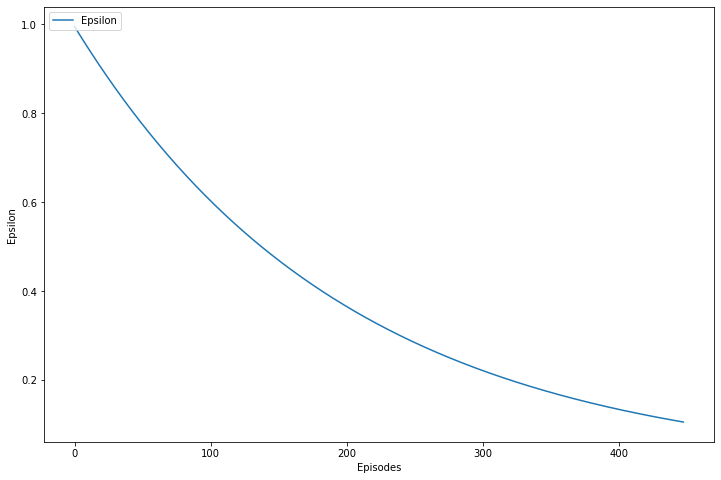

In [50]:
BUFFER_SIZE = 100000    # Màxima capacitat del buffer
BATCH_SIZE = 64         # Conjunt a agafar del buffer per a la xarxa neuronal
GAMMA = 0.99            # Valor gamma de l'equació de Bellman
TAU = 1e-3              # Valor de tau per a soft update del target network
LEARNING_RATE = 0.001   # Velocitat d'aprenentatge
DNN_UPD = 1             # Freqüència d'actualització de la xarxa neuronal

N_EPISODES=2000
MAX_T=1000 
EPS_START=1.0
EPS_MIN=0.01
EPS_DECAY=0.995
NBLOCK =100
MIN_EPISODES=250
REWARD_THRESHOLD = 200  # Valor de recompensa per a considerar l'entrenament com a completat

# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')
# inicialització de l'agent amb els paràmetres de l'exercici
agent = Agent(env, seed=0, learning_rate=LEARNING_RATE, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=DNN_UPD)
# entrenament de l'agent
scores = agent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, EPS_DECAY, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)

plot_rewards(agent)
plot_loss(agent)
plot_epsilon(agent)        
env.close()

Episode 49/50.

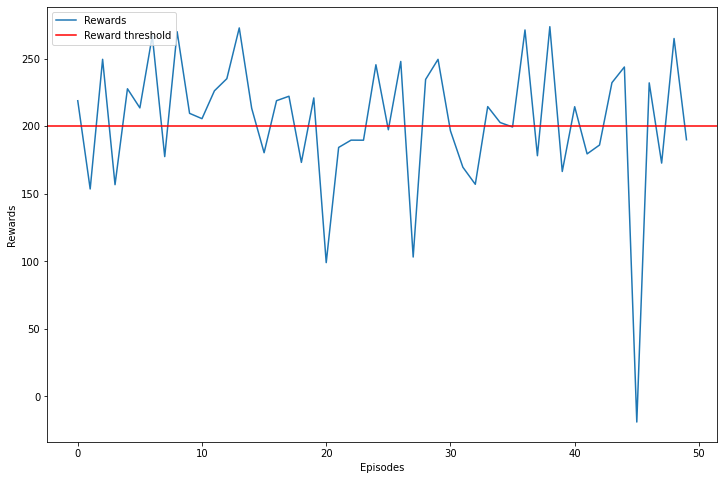

In [16]:
env = gym.make('LunarLander-v2')

def play_games(env, ag, num_games):    
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        env.reset()
        state = env.reset()           
        total_reward = 0
        done = False
        while not done:
            action = ag.get_action(state,eps=0.0)
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:    
                total_reward_list.append(total_reward)
    env.close()
    return total_reward_list      
          

def plot_rewards_min(agent, total_reward_list):
        plt.figure(figsize=(12,8))
        plt.plot(total_reward_list, label='Rewards')
        plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

total_reward_list = play_games(env, agent, 50)
plot_rewards_min(agent, total_reward_list)

TODO

## 6. Proposta de millora

En aquesta part es demana proposar una solució alternativa al problema de robòtica espacial que pugui ser més eficient respecte a allò que s'ha implementat anteriorment. 
Per assolir aquest objectiu, cal implementar un nou agent, basat en els algoritmes que hem vist al llarg de l’assignatura.

Es demana resoldre els 3 exercicis següents.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.1 (2 punts):</strong> Implementar l'agent identificat a l'entorn lunar-lander.
    
Justifiqueu les raons que han portat a provar aquest tipus d'observació entre les disponibles i perquè s'ha triat aquest tipus d'agent. Detalleu quins tipus de problemes s'espera que es puguin solucionar respecte a la implementació anterior
</div>

In [17]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F

class DDQNetwork(nn.Module):
    """ Deep Q-Network model  per a l'entrenament de l'agent DQN """
 
    def __init__(self, n_state, n_action, seed, n_layer1=64, n_layer2=64, n_layer3=64):
        """
        Inicialització de la xarxa neuronal
        Params
        =======
            n_state (int): Dimensions de l'espai d'estats
            n_action (int): Dimensions de l'espai d'accions
            n_layer1 (int): Nombre de nodes en la primera capa oculta
            n_layer2 (int): Nombre de nodes en la segona capa oculta
            seed (int): Random seed per a inicialitzar els valors aleatoris
        """
        super(DDQNetwork, self).__init__()
        self.seed = T.manual_seed(seed)
        self.fl1 = nn.Linear(n_state, n_layer1)
        self.fl2 = nn.Linear(n_layer1, n_layer2)

        self.advantage1 = nn.Linear(n_layer2, n_layer3)
        self.advantage2 = nn.Linear(n_layer3, n_action)

        self.value1 = nn.Linear(n_layer2, n_layer3)
        self.value2 = nn.Linear(n_layer3, 1)

    def forward(self, state):
        """
        Forward pass de la xarxa neuronal amb una capa oculta de 64 nodes i una capa de sortida de 4 nodes (una per cada acció)
        amb activació ReLU en les dues capes ocultes i activació lineal en la capa de sortida 
        """
        state = F.relu(self.fl1(state))
        state = F.relu(self.fl2(state))

        advantage = F.relu(self.advantage1(state))
        advantage = self.advantage2(advantage)

        value = F.relu(self.value1(state))
        value = self.value2(value)

        return value + advantage - advantage.mean()

In [18]:
class AgentDueling:
    """ Agent que interactua amb l'entorn i apren a través de DQN"""    
    def __init__(self, env, seed, learning_rate= 1e-3, gamma=0.99, tau=1e-3, buffer_size=100000, batch_size=64, dnn_upd=4):
        """ Inicialitza l'agent per a l'aprenentatge per DQN
            L'agent inicialitza la xarxa neuronal local i target, el buffer de memòria i l'optimitzador    
        Params
        ======
            env: Entorn de gym
            n_state (int): Dimensions de l'espai d'estats
            n_action (int): Dimensions de l'espai d'accions
            seed (int): Random seed per a inicialitzar els valors aleatoris
            learning_rate (float): Velocitat d'aprenentatge
            gamma (float): Valor gamma de l'equació de Bellman
            tau (float): Valor de tau per a soft update del target network
            buffer_size (int): Màxima capacitat del buffer
            batch_size (int): Conjunt a agafar del buffer per a la xarxa neuronal     
            dnn_upd (int): Freqüència d'actualització de la xarxa neuronal       
        """
        self.env = env
        self.seed = seed         
        self.n_state = env.observation_space.shape[0] 
        self.n_action = env.action_space.n
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.buffer_size = buffer_size
        self.batch_size = batch_size        
        self.dnn_upd = dnn_upd
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu") # Si hi ha GPU, utilitza-la

         
        random.seed(seed)   

        if T.cuda.is_available():
            print(f'Running on {T.cuda.get_device_name(0)}')            
        else:
            print('Running on CPU')
               
        # Inicialització de les xarxes locals i target i de l'optimitzador
        self.__initialize_networks()

    def __initialize_networks(self):
        # Inicialització de les xarxes locals i target            
        self.qnetwork_local = DDQNetwork(self.n_state, self.n_action, self.seed).to(self.device)
        self.qnetwork_target = DDQNetwork(self.n_state, self.n_action, self.seed).to(self.device)
        # Inicialització de l'optimitzador
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = self.learning_rate)

        # Inicialització del buffer de memòria
        self.memory = ReplayBuffer(self.n_action, self.buffer_size, self.batch_size, self.seed)
        
        # Inicialització del comptador de pasos per a l'actualització de la xarxa neuronal
        self.t_step = 0

    def __take_step(self, state, action, reward, next_state, done):
        """
        Afegeix l'experiència a la memòria i actualitza la xarxa neuronal
        """
        # emmagatzemar l'experiència en el buffer de memòria
        self.memory.append(state, action, reward, next_state, done)

        # Actualitzar la xarxa neuronal cada dnn_upd pasos
        self.t_step = (self.t_step + 1) % self.dnn_upd
        if self.t_step == 0:
            # Si hi ha suficients experiències en el buffer, agafar un lot i actualitzar la xarxa neuronal
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample_batch()
                self.__update(experiences, self.gamma)

    def get_action(self, state, eps):
        """
        Retorna l'acció segons l'estat actual i l'epsilon-greedy
        """
        state = T.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with T.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy per a seleccionar l'acció. 
        # Si el valor aleatori és més gran que l'epsilon agafar l'acció amb el valor més alt segons la xarxa neuronal
        # Si no, agafar una acció aleatòria
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.n_action))

    def __update(self, experiences, gamma):
        """
        Actualitza els pesos de la xarxa neuronal local i target
        """
        states, actions, rewards, next_states, dones = experiences

        # obtenir els valors Q de l'estat següent segons la xarxa neuronal target
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # calcular els valors Q segons l'equació de Bellman teni en compte si l'estat és terminal i el parametre gamma
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))

        # obtenir els valors Q de l'estat actual segons la xarxa neuronal local
        q_expected = self.qnetwork_local(states).gather(1, actions)

        # calcular la funció de pèrdua segons l'error quadràtic mitjà
        loss = F.mse_loss(q_expected, q_targets)

        # minimitzar la funció de pèrdua amb l'optimitzador
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

        # actualitzar els pesos de la xarxa neuronal target amb un soft update per a reduir el problema de l'estabilitat
        self.__soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def __soft_update(self, local_model, target_model, tau):
        """
        Soft update dels pesos de la xarxa neuronal target
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)    


    def train(self, n_episodes=2000, max_t=1000, eps_start=1.0, eps_min=0.01, eps_decay=0.995, nblock =100, min_episodes=250, reward_threshold=200.0):
        """Deep Q-Learning.

        Params
        ======
            n_episodes (int): nombre màxim d'episodis
            max_t (int): maxim nombre de pasos per episodi
            eps_start (float): valor inicial d'epsilon
            eps_min (float): valor mínim d'epsilon
            eps_decay (float): factor de decaig d'epsilon
        """
        self.reward_threshold = reward_threshold
        self.eps = eps_start  # inicialitzar epsilon
        self.nblock = nblock
        
        self.update_loss = [] 
        self.mean_update_loss = [] # llista amb els valors de la funció de pèrdua per episodi
        
        self.sync_eps = [] 

        self.training_rewards = []  # llista amb els reward per episodi
        self.mean_training_rewards = []  # llista amb la mitjana dels reward per episodi

        start_time = datetime.now()
        print("Training...")
        
        for episode in range(1, n_episodes + 1):
            state = self.env.reset()
            self.total_reward = 0   
            self.total_time = 0
            
            for t in range(max_t):
                action = self.get_action(state, self.eps)
                next_state, reward, done, _ = self.env.step(action)
                self.__take_step(state, action, reward, next_state, done)
                state = next_state
                self.total_reward += reward
                if done:
                    break

            # actualitzar epsilon
            self.eps = max(eps_min, eps_decay * self.eps)  # decrease epsilon            
            
            # afegir el reward de l'episodi a la llista
            self.__save_statistics()
            
            # mostrar informació de l'episodi actual
            self.__log_info(start_time, episode)
            
            ### comprovar si s'ha assolit el màxim d'episodis
            training = not self.__is_solved_by_episode(episode, n_episodes) and not self.__is_solved_by_reward(episode, min_episodes, self.__get_mean_training_rewards())
            
            ### si no s'ha assolit el màxim d'episodis, continuar entrenant
            if not training:
                print('\nTraining finished.')
                self.total_time = datetime.now() - start_time
                break

            if episode % 100 == 0:
                print('\rEpisode {}\tMean Rewards: {:.2f}\t'.format(episode, self.__get_mean_training_rewards()))
  

    def __get_mean_training_rewards(self):
        return np.mean(self.training_rewards[-self.nblock:])

    ######## Emmagatzemar epsilon, training rewards i loss#######
    def __save_statistics(self):
        self.sync_eps.append(self.eps)              
        self.training_rewards.append(self.total_reward)         
        self.mean_training_rewards.append(np.mean(self.training_rewards[-self.nblock:]))
        self.mean_update_loss.append(np.mean(self.update_loss))                                         
        self.update_loss = []
   
    ######## Comprovar si s'ha arribat al llindar de recompensa i un mínim d'episodis
    def __is_solved_by_reward(self, episode, min_episodios, mean_rewards):  
        if mean_rewards >= self.reward_threshold and min_episodios <  episode:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, mean_rewards))
            T.save(self.qnetwork_local.state_dict(), 'data.pth')
            return True
        else:
            return False

    ######## Comprovar si s'ha arribat al màxim d'episodis
    def __is_solved_by_episode(self, episode, max_episodes):
        if episode >= max_episodes:
            print('\nEpisode limit reached.')
            return True
        else:
            return False        


    ######## Mostrar informació de l'episodi actual
    def __log_info(self, start_time, episode):
        end_time = datetime.now()
        # get difference time
        delta = end_time - start_time 
        # time difference in minutes
        total_minutes = delta.total_seconds() / 60           
        print('\rEpisode {}\tMean Rewards: {:.2f}\tEpsilon {}\tTime {} minutes\t'
              .format(episode, self.__get_mean_training_rewards(), round(self.eps,4), round(total_minutes,2)), end="")                    

ModuleNotFoundError: No module named 'ex2_DDQN_NN'

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.2 (2 punts):</strong> Entrenar l'agent identificat i cercar els valors dels hiperparàmetres que obtinguin el
rendiment 'òptim' de l'agent.
</div>

In [ ]:
BUFFER_SIZE = 100000    # Màxima capacitat del buffer
BATCH_SIZE = 64         # Conjunt a agafar del buffer per a la xarxa neuronal
GAMMA = 0.99            # Valor gamma de l'equació de Bellman
TAU = 1e-3              # Valor de tau per a soft update del target network
LEARNING_RATE = 5e-4    # Velocitat d'aprenentatge
DNN_UPD = 3            # Freqüència d'actualització de la xarxa neuronal

N_EPISODES=2000
MAX_T=1000 
EPS_START=1.0
EPS_MIN=0.01
EPS_DECAY=0.995
NBLOCK =100
MIN_EPISODES=250
REWARD_THRESHOLD = 200  # Valor de recompensa per a considerar l'entrenament com a completat

# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')

# inicialització de l'agent amb els paràmetres de l'exercici

LEARNING_RATE = [1e-3, 5e-4, 1e-4]              # Velocitat d'aprenentatge
DNN_UPD = [1, 3, 5]                             # Freqüència d'actualització de la xarxa neuronal
EPS_DECAY = [0.99, 0.995]                       # Decaiment de l'exploració
agents = []
int n_test = 1
# iteració per a buscar els millors paràmetres
for lr in LEARNING_RATE:
    for upd in DNN_UPD:
        for eps in EPS_DECAY:
            print("Test number: {}", n_test)
            print("Learning rate: ", lr, " DNN update: ", upd, " Epsilon decay: ", eps)
            agent = AgentDueling(env, seed=0, learning_rate=lr, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=upd)
            scores = agent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, eps, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)
            agents.append(agent)
            print("Mean reward: ", agent.mean_training_rewards[-1])
            print("Mean loss: ", agent.mean_update_loss[-1])
            print("Epsilon: ", agent.sync_eps[-1])
            print("")
# tanquem l'entorn de gym
env.close()

In [ ]:
# plot de la recompensa de tots els agents en una mateixa gràfica
for agent in agents:
        plt.plot(agent.mean_training_rewards)        
        plt.legend(['Reward'])
        
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici 3.3 (2 punts):</strong> Analitzar el comportament de l'agent entrenat a l'entorn de prova i comparar-lo amb
l'agent implementat en el punt 2 (a través de gràfiques de les mètriques més oportunes).
</div>

In [ ]:
BUFFER_SIZE = 100000    # Màxima capacitat del buffer
BATCH_SIZE = 64         # Conjunt a agafar del buffer per a la xarxa neuronal
GAMMA = 0.99            # Valor gamma de l'equació de Bellman
TAU = 1e-3              # Valor de tau per a soft update del target network
LEARNING_RATE = 5e-4    # Velocitat d'aprenentatge
DNN_UPD = 3            # Freqüència d'actualització de la xarxa neuronal

N_EPISODES=2000
MAX_T=1000 
EPS_START=1.0
EPS_MIN=0.01
EPS_DECAY=0.995
NBLOCK =100
MIN_EPISODES=250
REWARD_THRESHOLD = 200  # Valor de recompensa per a considerar l'entrenament com a completat

# inicialització de l'entorn de gym
env = gym.make('LunarLander-v2')
# inicialització de l'agent amb els paràmetres de l'exercici
agent = Agent(env, seed=0, learning_rate=LEARNING_RATE, gamma=GAMMA, tau=TAU, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, dnn_upd=DNN_UPD)
# entrenament de l'agent
scores = agent.train(N_EPISODES, MAX_T, EPS_START, EPS_MIN, EPS_DECAY, NBLOCK, MIN_EPISODES, REWARD_THRESHOLD)

plot_rewards(agent)
plot_loss(agent)
plot_epsilon(agent)        
env.close()

In [ ]:
env = gym.make('LunarLander-v2')

def play_games(env, ag, num_games):    
    total_reward_list = []    
    for i_game in range(num_games): 
        if i_game % 1 == 0:
            print("\rEpisode {}/{}.".format(i_game, num_games), end="")
            sys.stdout.flush()
            
        env.reset()
        state = env.reset()           
        total_reward = 0
        done = False
        while not done:
            action = ag.get_action(state,eps=0.0)
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:    
                total_reward_list.append(total_reward)
    env.close()
    return total_reward_list      
          

def plot_rewards_min(agent, total_reward_list):
        plt.figure(figsize=(12,8))
        plt.plot(total_reward_list, label='Rewards')
        plt.axhline(agent.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()

total_reward_list = play_games(env, agent, 50)
plot_rewards_min(agent, total_reward_list)